# Basics

## Quickstart
### Working with data
PyTorch has two primitives to work with data: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset`.

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), all of which
include datasets. For this tutorial, we will be using a TorchVision
dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list
here](https://pytorch.org/vision/stable/datasets.html)). In this
tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.

In [3]:
# Download training data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:03<00:00, 7967741.55it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209638.13it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 681541.68it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5331426.42it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the `Dataset` as an argument to `DataLoader`. This wraps an
iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.


In [4]:
batch_size = 64

# create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Creating Models

To define a neural network in PyTorch, we create a class that inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.


In [6]:
# Get cpu, gpu or mps device for training
device = ("cuda" if torch.cuda.is_available()
          else "cpu")
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stak = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stak(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stak): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an [optimizer](https://pytorch.org/docs/stable/optim.html).


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model\'s parameters.

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

We also check the model\'s performance against the test dataset to
ensure it is learning.

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.312702 [   64/60000]
loss: 2.302686 [ 6464/60000]
loss: 2.273867 [12864/60000]
loss: 2.261350 [19264/60000]
loss: 2.255846 [25664/60000]
loss: 2.224161 [32064/60000]
loss: 2.225834 [38464/60000]
loss: 2.197489 [44864/60000]
loss: 2.193152 [51264/60000]
loss: 2.153397 [57664/60000]
Test Error: 
 Accuracy: 35.4%, Avg loss: 2.156094 

Epoch 2
-------------------------------
loss: 2.177377 [   64/60000]
loss: 2.168272 [ 6464/60000]
loss: 2.102842 [12864/60000]
loss: 2.112488 [19264/60000]
loss: 2.071274 [25664/60000]
loss: 2.012736 [32064/60000]
loss: 2.037289 [38464/60000]
loss: 1.961162 [44864/60000]
loss: 1.961603 [51264/60000]
loss: 1.890148 [57664/60000]
Test Error: 
 Accuracy: 49.2%, Avg loss: 1.888956 

Epoch 3
-------------------------------
loss: 1.933108 [   64/60000]
loss: 1.903405 [ 6464/60000]
loss: 1.777747 [12864/60000]
loss: 1.816611 [19264/60000]
loss: 1.707883 [25664/60000]
loss: 1.663428 [32064/60000]
loss: 1.687826 [38464/

### Saving Models
A common way to save a model is to serialize the internal state
dictionary (containing the model parameters).

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

### Loading models
The process for loading a model includes re-creating the model structure and loading the state dictionary into it.


In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

This model can now be used to make predictions.

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

## Tensors
Like array, but can run on GPU.

In [1]:
import torch
import numpy as np

### Initializing Tensor
Directly from data

In [2]:
data = [[1, 2], [3, 4]]
print(data)
x_data = torch.tensor(data)
print(x_data)

[[1, 2], [3, 4]]
tensor([[1, 2],
        [3, 4]])


**From numpy array.**

In [3]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

**From another tensor**, new tensor keep shape and datatype of old tensor.

In [4]:
x_ones = torch.ones_like(x_data) # retains properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides dtype
print(f"Ones Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Ones Tensor: 
 tensor([[0.2128, 0.8975],
        [0.8850, 0.3905]]) 



**With random or constant values:**

`shape` is a tuple of tensor dimensions. In the functions below, it
determines the dimensionality of the output tensor.

In [5]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.5674, 0.6799, 0.2115],
        [0.6086, 0.1519, 0.2078]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


### Attributes of a Tensor

Tensor attributes describe their shape, datatype, and the device on
which they are stored.

In [6]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


### Tensor operations

In [7]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

In [8]:
tensor = torch.rand(4, 4)
print(f"First row: {tensor[0, :]}")
print(f"First column: {tensor[:,0]}")
print(f"Last column: {tensor[...,-1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([0.8542, 0.7970, 0.1524, 0.4318])
First column: tensor([0.8542, 0.9904, 0.2437, 0.6107])
Last column: tensor([0.4318, 0.7757, 0.8978, 0.2656])
tensor([[0.8542, 0.0000, 0.1524, 0.4318],
        [0.9904, 0.0000, 0.5376, 0.7757],
        [0.2437, 0.0000, 0.2167, 0.8978],
        [0.6107, 0.0000, 0.6186, 0.2656]])


**Joining tensors** `torch.cat` to concatenate tensors.

In [9]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[0.8542, 0.0000, 0.1524, 0.4318, 0.8542, 0.0000, 0.1524, 0.4318, 0.8542,
         0.0000, 0.1524, 0.4318],
        [0.9904, 0.0000, 0.5376, 0.7757, 0.9904, 0.0000, 0.5376, 0.7757, 0.9904,
         0.0000, 0.5376, 0.7757],
        [0.2437, 0.0000, 0.2167, 0.8978, 0.2437, 0.0000, 0.2167, 0.8978, 0.2437,
         0.0000, 0.2167, 0.8978],
        [0.6107, 0.0000, 0.6186, 0.2656, 0.6107, 0.0000, 0.6186, 0.2656, 0.6107,
         0.0000, 0.6186, 0.2656]])


**Arithmatic operations**

In [ ]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

**Single-element tensors** If you have a one-element tensor, for example
by aggregating all values of a tensor into one value, you can convert it
to a Python numerical value using `item()`:


In [ ]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

**In-place operations** Operations that store the result into the
operand are called in-place. They are denoted by a `_` suffix. For
example: `x.copy_(y)`, `x.t_()`, will change `x`.


In [ ]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

### Bridge with numpy
Tensors on the CPU and NumPy arrays can share their underlying memory
locations, and changing one will change the other.


**Tensor to NumPy array**

In [ ]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

n = np.ones(5)
t = torch.from_numpy(n)

## Datasets and Dataloaders

Code for processing data samples can get messy and hard to maintain; we
ideally want our dataset code to be decoupled from our model training
code for better readability and modularity. PyTorch provides two data
primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`
that allow you to use pre-loaded datasets as well as your own data.
`Dataset` stores the samples and their corresponding labels, and
`DataLoader` wraps an iterable around the `Dataset` to enable easy
access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such
as FashionMNIST) that subclass `torch.utils.data.Dataset` and implement
functions specific to the particular data. They can be used to prototype
and benchmark your model. You can find them here: [Image
Datasets](https://pytorch.org/vision/stable/datasets.html), [Text
Datasets](https://pytorch.org/text/stable/datasets.html), and [Audio
Datasets](https://pytorch.org/audio/stable/datasets.html)

### Loading a Dataset
Here is an example of how to load the
[Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/)
dataset from TorchVision. Fashion-MNIST is a dataset of Zalando's
article images consisting of 60,000 training examples and 10,000 test
examples. Each example comprises a 28×28 grayscale image and an
associated label from one of 10 classes.

We load the [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) with the following parameters:

:   -   `root` is the path where the train/test data is stored,
    -   `train` specifies training or test dataset,
    -   `download=True` downloads the data from the internet if it\'s
        not available at `root`.
    -   `transform` and `target_transform` specify the feature and label
        transformations


In [11]:
%matplotlib inline

In [12]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### Iterating and Visualizing the Dataset

We can index `Datasets` manually like a list: `training_data[index]`. We
use `matplotlib` to visualize some samples in our training data.


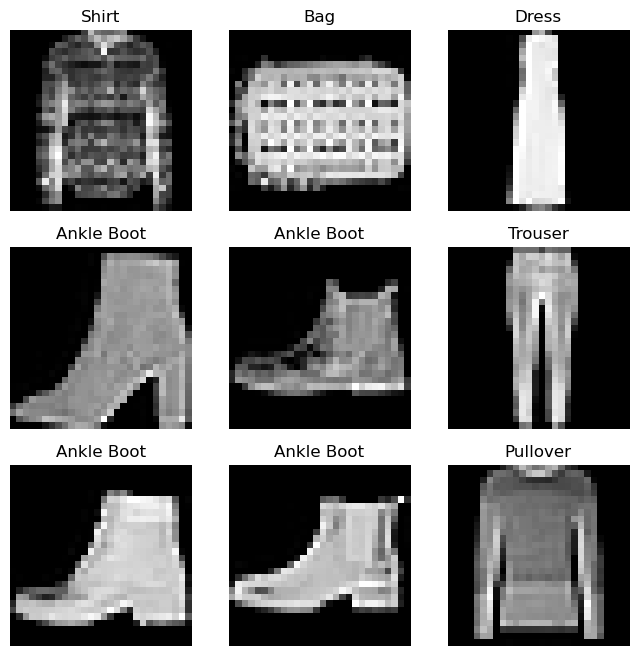

In [13]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files

A custom Dataset class must implement three functions:
[\_\_init\_\_]{.title-ref}, [\_\_len\_\_]{.title-ref}, and
[\_\_getitem\_\_]{.title-ref}. Take a look at this implementation; the
FashionMNIST images are stored in a directory `img_dir`, and their
labels are stored separately in a CSV file `annotations_file`.

In the next sections, we\'ll break down what\'s happening in each of
these functions.


In [14]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

`__init__`

The \_\_[init]() function is run once when instantiating the Dataset
object. We initialize the directory containing the images, the
annotations file, and both transforms (covered in more detail in the
next section).

The labels.csv file looks like: :

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9

`__len__`

The \_\_[len]() function returns the number of samples in our dataset.

`__getitem__`

The \_\_[getitem]() function loads and returns a sample from the dataset
at the given index `idx`. Based on the index, it identifies the image\'s
location on disk, converts that to a tensor using `read_image`,
retrieves the corresponding label from the csv data in
`self.img_labels`, calls the transform functions on them (if
applicable), and returns the tensor image and corresponding label in a
tuple.


### Preparing your data for training with DataLoaders

The `Dataset` retrieves our dataset\'s features and labels one sample at
a time. While training a model, we typically want to pass samples in
\"minibatches\", reshuffle the data at every epoch to reduce model
overfitting, and use Python\'s `multiprocessing` to speed up data
retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an
easy API.


In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the DataLoader

We have loaded that dataset into the `DataLoader` and can iterate
through the dataset as needed. Each iteration below returns a batch of
`train_features` and `train_labels` (containing `batch_size=64` features
and labels respectively). Because we specified `shuffle=True`, after we
iterate over all batches the data is shuffled (for finer-grained control
over the data loading order, take a look at
[Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


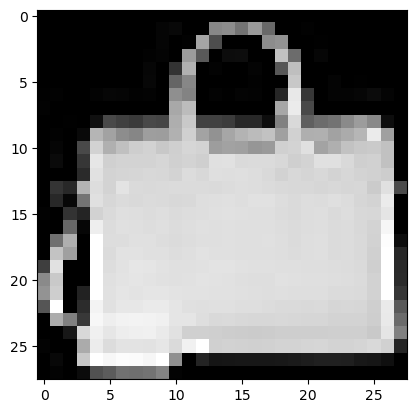

Label: 8


In [17]:
# Display image and label.

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Transforms

Data does not always come in its final processed form that is required
for training machine learning algorithms. We use **transforms** to
perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -`transform` to modify the
features and `target_transform` to modify the labels - that accept
callables containing the transformation logic. The
[torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)
module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are
integers. For training, we need the features as normalized tensors, and
the labels as one-hot encoded tensors. To make these transformations, we
use `ToTensor` and `Lambda`.

### ToTensor()

[ToTensor](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor)
converts a PIL image or NumPy `ndarray` into a `FloatTensor`. and scales
the image\'s pixel intensity values in the range \[0., 1.\]

### Lambda Transforms

Lambda transforms apply any user-defined lambda function. Here, we
define a function to turn the integer into a one-hot encoded tensor. It
first creates a zero tensor of size 10 (the number of labels in our
dataset) and calls
[scatter\_](https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_.html)
which assigns a `value=1` on the index as given by the label `y`.


In [ ]:
%matplotlib inline

In [18]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

## Build Model
### Build the Neural Network

Neural networks comprise of layers/modules that perform operations on
data. The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace
provides all the building blocks you need to build your own neural
network. Every module in PyTorch subclasses the
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
A neural network is a module itself that consists of other modules
(layers). This nested structure allows for building and managing complex
architectures easily.

In the following sections, we\'ll build a neural network to classify
images in the FashionMNIST dataset.


In [20]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Define the Class

We define our neural network by subclassing `nn.Module`, and initialize
the neural network layers in `__init__`. Every `nn.Module` subclass
implements the operations on input data in the `forward` method.


In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [23]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model\'s
`forward`, along with some [background
operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866).
Do not call `model.forward()` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0
corresponding to each output of 10 raw predicted values for each class,
and dim=1 corresponding to the individual values of each output. We get
the prediction probabilities by passing it through an instance of the
`nn.Softmax` module.


In [24]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([4], device='cuda:0')


### Model Layers

Let\'s break down the layers in the FashionMNIST model. To illustrate
it, we will take a sample minibatch of 3 images of size 28x28 and see
what happens to it as we pass it through the network.


In [27]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten

We initialize the
[nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
layer to convert each 2D 28x28 image into a contiguous array of 784
pixel values ( the minibatch dimension (at dim=0) is maintained).


In [28]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear

The [linear
layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using its
stored weights and biases.


In [29]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU

Non-linear activations are what create the complex mappings between the
model\'s inputs and outputs. They are applied after linear
transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use
[nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
between our linear layers, but there\'s other activations to introduce
non-linearity in your model.


In [30]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-3.1540e-02, -1.5555e-01, -4.0794e-01, -1.6999e-01, -6.4646e-02,
         -1.9358e-01, -2.2942e-01, -3.8007e-02, -3.2575e-01, -3.3794e-01,
         -2.9540e-01, -1.9502e-01, -1.8220e-01,  4.0613e-02,  2.2113e-02,
          5.2996e-02, -3.3352e-02,  3.4086e-01, -3.0559e-02, -2.6503e-01],
        [-3.4629e-01,  6.6547e-02, -7.7879e-01, -2.7901e-01, -4.9018e-02,
         -4.3725e-01,  1.1751e-01, -3.2069e-01, -4.1478e-01,  7.1298e-02,
          3.0193e-01, -6.1575e-02, -2.5639e-01,  6.4421e-02, -2.6663e-01,
         -1.1187e-04, -2.1553e-01,  2.7886e-01,  1.7046e-01, -3.3301e-01],
        [-3.1233e-01,  4.5994e-01, -4.7507e-01, -2.7212e-02, -6.2979e-02,
         -2.8331e-01, -2.6563e-01, -2.7401e-01, -9.3969e-02,  2.5433e-01,
         -1.8697e-01,  1.0256e-02, -3.3530e-01,  8.3531e-03,  2.2403e-01,
         -1.7757e-01,  1.4530e-01,  4.5996e-01,  6.1837e-02, -4.3811e-01]],
       grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

### nn.Sequential

[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
is an ordered container of modules. The data is passed through all the
modules in the same order as defined. You can use sequential containers
to put together a quick network like `seq_modules`.


In [31]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### nn.Softmax

The last linear layer of the neural network returns [logits]{.title-ref}
- raw values in \[-infty, infty\] - which are passed to the
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
module. The logits are scaled to values \[0, 1\] representing the
model\'s predicted probabilities for each class. `dim` parameter
indicates the dimension along which the values must sum to 1.


In [32]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

### Model Parameters

Many layers inside a neural network are *parameterized*, i.e. have
associated weights and biases that are optimized during training.
Subclassing `nn.Module` automatically tracks all fields defined inside
your model object, and makes all parameters accessible using your
model\'s `parameters()` or `named_parameters()` methods.

In this example, we iterate over each parameter, and print its size and
a preview of its values.


In [33]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0348, -0.0308, -0.0048,  ...,  0.0120,  0.0327,  0.0125],
        [ 0.0046,  0.0287,  0.0287,  ...,  0.0183, -0.0086,  0.0185]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0026, -0.0231], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0196, -0.0005, -0.0050,  ...,  0.0310, -0.0013, -0.0398],
        [-0.0090,  0.0228, -0.0256,  ..., -0.0274,  0.0072, -0.0119]],
       device='cuda:0', grad_fn=<Sl

## Automatic Differentiation with `torch.autograd`

When training neural networks, the most frequently used algorithm is
**back propagation**. In this algorithm, parameters (model weights) are
adjusted according to the **gradient** of the loss function with respect
to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation
engine called `torch.autograd`. It supports automatic computation of
gradient for any computational graph.

Consider the simplest one-layer neural network, with input `x`,
parameters `w` and `b`, and some loss function. It can be defined in
PyTorch in the following manner:


In [1]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

### Tensors, Functions and Computational graph

This code defines the following **computational graph**:

![](https://pytorch.org/tutorials/_static/img/basics/comp-graph.png)

In this network, `w` and `b` are **parameters**, which we need to
optimize. Thus, we need to be able to compute the gradients of loss
function with respect to those variables. In order to do that, we set
the `requires_grad` property of those tensors.


A function that we apply to tensors to construct computational graph is
in fact an object of class `Function`. This object knows how to compute
the function in the *forward* direction, and also how to compute its
derivative during the *backward propagation* step. A reference to the
backward propagation function is stored in `grad_fn` property of a
tensor. You can find more information of `Function` [in the
documentation](https://pytorch.org/docs/stable/autograd.html#function).


In [2]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7a3bec6c97e0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7a3bec6c9600>


### Computing Gradients

To optimize weights of parameters in the neural network, we need to
compute the derivatives of our loss function with respect to parameters,
namely, we need $\frac{\partial loss}{\partial w}$ and
$\frac{\partial loss}{\partial b}$ under some fixed values of `x` and
`y`. To compute those derivatives, we call `loss.backward()`, and then
retrieve the values from `w.grad` and `b.grad`:


In [3]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.3007, 0.3030, 0.2859],
        [0.3007, 0.3030, 0.2859],
        [0.3007, 0.3030, 0.2859],
        [0.3007, 0.3030, 0.2859],
        [0.3007, 0.3030, 0.2859]])
tensor([0.3007, 0.3030, 0.2859])


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<ul>
<li>We can only obtain the <code>grad</code> properties for the leafnodes of the computational graph, which have <code>requires_grad</code> propertyset to <code>True</code>. For all other nodes in our graph, gradients will not beavailable.- We can only perform gradient calculations using<code>backward</code> once on a given graph, for performance reasons. If we needto do several <code>backward</code> calls on the same graph, we need to pass<code>retain_graph=True</code> to the <code>backward</code> call.</li>
</ul>
</div>


### Disabling Gradient Tracking

By default, all tensors with `requires_grad=True` are tracking their
computational history and support gradient computation. However, there
are some cases when we do not need to do that, for example, when we have
trained the model and just want to apply it to some input data, i.e. we
only want to do *forward* computations through the network. We can stop
tracking computations by surrounding our computation code with
`torch.no_grad()` block:


In [4]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the `detach()` method
on the tensor:


In [5]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


There are reasons you might want to disable gradient tracking:

:   -   To mark some parameters in your neural network as **frozen
        parameters**.
    -   To **speed up computations** when you are only doing forward
        pass, because computations on tensors that do not track
        gradients would be more efficient.


### More on Computational Graphs

Conceptually, autograd keeps a record of data (tensors) and all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of
[Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
objects. In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

-   run the requested operation to compute a resulting tensor
-   maintain the operation's *gradient function* in the DAG.

The backward pass kicks off when `.backward()` is called on the DAG
root. `autograd` then:

-   computes the gradients from each `.grad_fn`,
-   accumulates them in the respective tensor's `.grad` attribute
-   using the chain rule, propagates all the way to the leaf tensors.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>An important thing to note is that the graph is recreated from scratch; after each<code>.backward()</code> call, autograd starts populating a new graph. This isexactly what allows you to use control flow statements in your model;you can change the shape, size and operations at every iteration ifneeded.</p>
</div>


### Optional Reading: Tensor Gradients and Jacobian Products

In many cases, we have a scalar loss function, and we need to compute
the gradient with respect to some parameters. However, there are cases
when the output function is an arbitrary tensor. In this case, PyTorch
allows you to compute so-called **Jacobian product**, and not the actual
gradient.

For a vector function $\vec{y}=f(\vec{x})$, where
$\vec{x}=\langle x_1,\dots,x_n\rangle$ and
$\vec{y}=\langle y_1,\dots,y_m\rangle$, a gradient of $\vec{y}$ with
respect to $\vec{x}$ is given by **Jacobian matrix**:

$$\begin{aligned}
J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)
\end{aligned}$$

Instead of computing the Jacobian matrix itself, PyTorch allows you to
compute **Jacobian Product** $v^T\cdot J$ for a given input vector
$v=(v_1 \dots v_m)$. This is achieved by calling `backward` with $v$ as
an argument. The size of $v$ should be the same as the size of the
original tensor, with respect to which we want to compute the product:


In [6]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Notice that when we call `backward` for the second time with the same
argument, the value of the gradient is different. This happens because
when doing `backward` propagation, PyTorch **accumulates the
gradients**, i.e. the value of computed gradients is added to the `grad`
property of all leaf nodes of computational graph. If you want to
compute the proper gradients, you need to zero out the `grad` property
before. In real-life training an *optimizer* helps us to do this.


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>Previously we were calling <code>backward()</code> function withoutparameters. This is essentially equivalent to calling<code>backward(torch.tensor(1.0))</code>, which is a useful way to compute thegradients in case of a scalar-valued function, such as loss duringneural network training.</p>
</div>


## Optimization Loop

### Optimizing Model Parameters

Now that we have a model and data it\'s time to train, validate and test
our model by optimizing its parameters on our data. Training a model is
an iterative process; in each iteration the model makes a guess about
the output, calculates the error in its guess (*loss*), collects the
derivatives of the error with respect to its parameters (as we saw in
the [previous section](autograd_tutorial.html)), and **optimizes** these
parameters using gradient descent. For a more detailed walkthrough of
this process, check out this video on [backpropagation from
3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

Prerequisite Code
-----------------

We load the code from the previous sections on [Datasets &
DataLoaders](data_tutorial.html) and [Build
Model](buildmodel_tutorial.html).


In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

### Hyperparameters

Hyperparameters are adjustable parameters that let you control the model
optimization process. Different hyperparameter values can impact model
training and convergence rates ([read
more](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)
about hyperparameter tuning)

We define the following hyperparameters for training:

:   -   **Number of Epochs** - the number times to iterate over the
        dataset
    -   **Batch Size** - the number of data samples propagated through
        the network before the parameters are updated
    -   **Learning Rate** - how much to update models parameters at each
        batch/epoch. Smaller values yield slow learning speed, while
        large values may result in unpredictable behavior during
        training.


In [8]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

### Optimization Loop

Once we set our hyperparameters, we can then train and optimize our
model with an optimization loop. Each iteration of the optimization loop
is called an **epoch**.

Each epoch consists of two main parts:

:   -   **The Train Loop** - iterate over the training dataset and try
        to converge to optimal parameters.
    -   **The Validation/Test Loop** - iterate over the test dataset to
        check if model performance is improving.

Let\'s briefly familiarize ourselves with some of the concepts used in
the training loop. Jump ahead to see the
`full-impl-label`{.interpreted-text role="ref"} of the optimization
loop.

#### Loss Function

When presented with some training data, our untrained network is likely
not to give the correct answer. **Loss function** measures the degree of
dissimilarity of obtained result to the target value, and it is the loss
function that we want to minimize during training. To calculate the loss
we make a prediction using the inputs of our given data sample and
compare it against the true data label value.

Common loss functions include
[nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
(Mean Square Error) for regression tasks, and
[nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss)
(Negative Log Likelihood) for classification.
[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
combines `nn.LogSoftmax` and `nn.NLLLoss`.

We pass our model\'s output logits to `nn.CrossEntropyLoss`, which will
normalize the logits and compute the prediction error.


In [9]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce
model error in each training step. **Optimization algorithms** define
how this process is performed (in this example we use Stochastic
Gradient Descent). All optimization logic is encapsulated in the
`optimizer` object. Here, we use the SGD optimizer; additionally, there
are many [different
optimizers](https://pytorch.org/docs/stable/optim.html) available in
PyTorch such as ADAM and RMSProp, that work better for different kinds
of models and data.

We initialize the optimizer by registering the model\'s parameters that
need to be trained, and passing in the learning rate hyperparameter.


In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:

:   -   Call `optimizer.zero_grad()` to reset the gradients of model
        parameters. Gradients by default add up; to prevent
        double-counting, we explicitly zero them at each iteration.
    -   Backpropagate the prediction loss with a call to
        `loss.backward()`. PyTorch deposits the gradients of the loss
        w.r.t. each parameter.
    -   Once we have our gradients, we call `optimizer.step()` to adjust
        the parameters by the gradients collected in the backward pass.


In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295837  [   64/60000]
loss: 2.293579  [ 6464/60000]
loss: 2.272922  [12864/60000]
loss: 2.270849  [19264/60000]
loss: 2.263756  [25664/60000]
loss: 2.222189  [32064/60000]
loss: 2.237807  [38464/60000]
loss: 2.196224  [44864/60000]
loss: 2.189372  [51264/60000]
loss: 2.169547  [57664/60000]
Test Error: 
 Accuracy: 37.8%, Avg loss: 2.157363 

Epoch 2
-------------------------------
loss: 2.157923  [   64/60000]
loss: 2.159187  [ 6464/60000]
loss: 2.095220  [12864/60000]
loss: 2.115452  [19264/60000]
loss: 2.085444  [25664/60000]
loss: 2.005141  [32064/60000]
loss: 2.042828  [38464/60000]
loss: 1.950053  [44864/60000]
loss: 1.950055  [51264/60000]
loss: 1.900573  [57664/60000]
Test Error: 
 Accuracy: 60.7%, Avg loss: 1.886302 

Epoch 3
-------------------------------
loss: 1.903745  [   64/60000]
loss: 1.892251  [ 6464/60000]
loss: 1.762474  [12864/60000]
loss: 1.813374  [19264/60000]
loss: 1.737207  [25664/60000]
loss: 1.656015  [32064/600

## Save, Load and Use Model

In [14]:
import torch
import torchvision.models as models

### Saving and Loading Model Weights

PyTorch models store the learned parameters in an internal state
dictionary, called `state_dict`. These can be persisted via the
`torch.save` method:

In [15]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/sunzid/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:15<00:00, 35.8MB/s] 


To load model weights, you need to create an instance of the same model
first, and then load the parameters using `load_state_dict()` method.


In [16]:
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>be sure to call <code>model.eval()</code> method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.</p>
</div>


### Saving and Loading Models with Shapes

When loading model weights, we needed to instantiate the model class
first, because the class defines the structure of a network. We might
want to save the structure of this class together with the model, in
which case we can pass `model` (and not `model.state_dict()`) to the
saving function:


In [17]:
torch.save(model, 'model.pth')

In [18]:
model = torch.load('model.pth')

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>This approach uses Python <a href="https://docs.python.org/3/library/pickle.html">pickle</a> module when serializing the model, thus it relies on the actual class definition to be available when loading the model.</p>
</div>


# RL

## DQN Tutorial on CartPole

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find more
information about the environment and other more challenging
environments at [Gymnasium\'s
website](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

![CartPole](https://pytorch.org/tutorials/_static/img/cartpole.gif)

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, rewards are +1 for every incremental timestep and the environment
terminates if the pole falls over too far or the cart moves more than
2.4 units away from center. This means better performing scenarios will
run for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.). We
take these 4 inputs without any scaling and pass them through a small
fully-connected network with 2 outputs, one for each action. The network
is trained to predict the expected value for each action, given the
input state. The action with the highest expected value is then chosen.


In [4]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

### Replay Memory

We\'ll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we\'re going to need two classes:

-   `Transition` - a named tuple representing a single transition in our
    environment. It essentially maps (state, action) pairs to their
    (next\_state, reward) result, with the state being the screen
    difference image as described later on.
-   `ReplayMemory` - a cyclic buffer of bounded size that holds the
    transitions observed recently. It also implements a `.sample()`
    method for selecting a random batch of transitions for training.


In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let\'s define our model. But first, let\'s quickly recap what a DQN
is.

### DQN algorithm

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where $R_{t_0}$
is also known as the *return*. The discount, $\gamma$, should be a
constant between $0$ and $1$ that ensures the sum converges. A lower
$\gamma$ makes rewards from the uncertain far future less important for
our agent than the ones in the near future that it can be fairly
confident about. It also encourages agents to collect reward closer in
time than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell us
what our return would be, if we were to take an action in a given state,
then we could easily construct a policy that maximizes our rewards:

$$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$$

However, we don\'t know everything about the world, so we don\'t have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble $Q^*$.

For our training update rule, we\'ll use a fact that every $Q$ function
for some policy obeys the Bellman equation:

$$Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))$$

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

$$\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))$$

To minimize this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate this
over a batch of transitions, $B$, sampled from the replay memory:

$$\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)$$

$$\begin{aligned}
\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
  \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
  |\delta| - \frac{1}{2} & \text{otherwise.}
\end{cases}
\end{aligned}$$

Q-network
---------

Our model will be a feed forward neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$
(where $s$ is the input to the network). In effect, the network is
trying to predict the *expected return* of taking each action given the
current input.


In [6]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Training

Hyperparameters and utilities
-----------------------------

This cell instantiates our model and its optimizer, and defines some
utilities:

-   `select_action` - will select an action according to an epsilon
    greedy policy. Simply put, we\'ll sometimes use our model for
    choosing the action, and sometimes we\'ll just sample one uniformly.
    The probability of choosing a random action will start at
    `EPS_START` and will decay exponentially towards `EPS_END`.
    `EPS_DECAY` controls the rate of the decay.
-   `plot_durations` - a helper for plotting the duration of episodes,
    along with an average over the last 100 episodes (the measure used
    in the official evaluations). The plot will be underneath the cell
    containing the main training loop, and will update after every
    episode.


In [7]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Training loop

Finally, the code for training our model.

Here, you can find an `optimize_model` function that performs a single
step of the optimization. It first samples a batch, concatenates all the
tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our loss. By
definition we set $V(s) = 0$ if $s$ is a terminal state. We also use a
target network to compute $V(s_{t+1})$ for added stability. The target
network is updated at every step with a [soft
update](https://arxiv.org/pdf/1509.02971.pdf) controlled by the
hyperparameter `TAU`, which was previously defined.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple, deque

# Define the transition tuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Dummy replay memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Define a simple neural network for policy and target nets
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

# Hyperparameters
BATCH_SIZE = 4
GAMMA = 0.99
input_size = 2
output_size = 2
learning_rate = 0.001

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks
policy_net = SimpleNet(input_size, output_size).to(device)
target_net = SimpleNet(input_size, output_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Initialize optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Initialize replay memory
memory = ReplayMemory(10000)

# Populate replay memory with dummy data
for _ in range(10):
    state = torch.rand((1, input_size), device=device)
    action = torch.tensor([[random.randrange(output_size)]], device=device)
    next_state = torch.rand((1, input_size), device=device) if random.random() > 0.5 else None
    reward = torch.tensor([random.random()], device=device)
    memory.push(state, action, next_state, reward)

# Define the optimize_model function
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    # Print outputs for demonstration
    print("State Batch:")
    print(state_batch)
    print("Action Batch:")
    print(action_batch)
    print("Reward Batch:")
    print(reward_batch)
    print("State-Action Values:")
    print(state_action_values)
    print("Next State Values:")
    print(next_state_values)
    print("Expected State-Action Values:")
    print(expected_state_action_values)
    print("Loss:")
    print(loss.item())

# Run a single optimization loop
optimize_model()


State Batch:
tensor([[0.7745, 0.6473],
        [0.8660, 0.0287],
        [0.1187, 0.7957],
        [0.7061, 0.4107]], device='cuda:0')
Action Batch:
tensor([[1],
        [0],
        [0],
        [0]], device='cuda:0')
Reward Batch:
tensor([0.8921, 0.3901, 0.2667, 0.5895], device='cuda:0')
State-Action Values:
tensor([[-0.5784],
        [ 1.1745],
        [ 0.2828],
        [ 0.8721]], device='cuda:0', grad_fn=<GatherBackward0>)
Next State Values:
tensor([0.4592, 0.9632, 0.6243, 0.0000], device='cuda:0')
Expected State-Action Values:
tensor([1.3467, 1.3437, 0.8848, 0.5895], device='cuda:0')
Loss:
0.41513964533805847


In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial `state` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always 1),
and optimize our model once. When the episode ends (our model fails), we
restart the loop.

Below, [num\_episodes]{.title-ref} is set to 600 if a GPU is available,
otherwise 50 episodes are scheduled so training does not take too long.
However, 50 episodes is insufficient for to observe good performance on
CartPole. You should see the model constantly achieve 500 steps within
600 training episodes. Training RL agents can be a noisy process, so
restarting training can produce better results if convergence is not
observed.


Complete


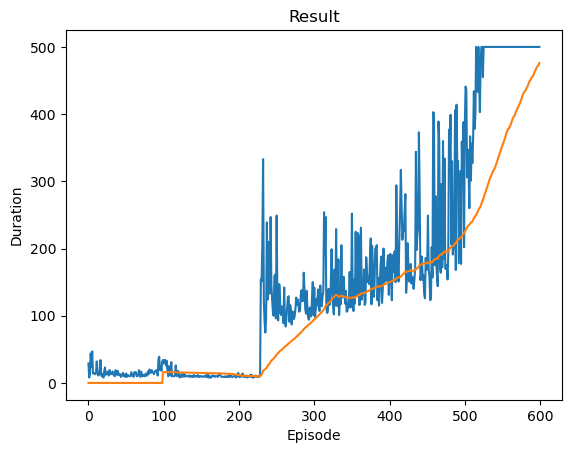

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Here is the diagram that illustrates the overall resulting data flow.

![](https://pytorch.org/tutorials/_static/img/reinforcement_learning_diagram.jpg)

Actions are chosen either randomly or based on a policy, getting the
next step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training
of the new policy. The \"older\" target\_net is also used in
optimization to compute the expected Q values. A soft update of its
weights are performed at every step.
